### NEEDS TO BE RUN UNDER PYTHON2 (or the large jobs rerun to joblib dump in python 3).

Contents.

* Summary of previous paper.
* Examination of cases where random beats ridge.
* Examination of some cases where rf/tanimoto beats ridge.
* Generalized loss function NTF.
* Approximating WIA results with NTF loss function.
* NTF results all datasets.
* Conclusion

In [1]:
from __future__ import division, print_function

In [2]:
import joblib
import numpy as np
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock
from scipy import stats

In [3]:
# Uncomment for exploration of molecules - only in py2.7
#from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole

### Summary of previous paper

Should put in a summary of the previous paper here - point out that this extends that one.  I'm not actually convinced any more that it's worth delving too much into the individual cases in the previous paper - given that we'll show later that the 'ollie_params' (aka take all targets out bar one) gives highly misleading results once the thresholds are close together.

We'll refer to the previous paper ('Which iterative algorithm...) as [WIA] throughout.

#### Examination of cases whre random beats ridge.

HERG on 7-8.  7-8 on ERB1.  In general - how good is Ridge generally.


#### Examination of cases where rf (or other methods) beat ridge.

From WIA - one of the big examples where rf beats ridge is COX1 5-9.  Also Tanimoto (any number) 7-9 Caspase. Tanimoto 7-8 Estrogen.  Tanimoto 5-9 on Caspase. RF 5-9 on ABL1 and RF (and even more just linear?) on A2a.

### Generalized loss function NTF

All of the modelling methods we examined in [WIA] give us either a prediction of PIC50 on the test set, or a ranking of 'most likely to be the top PIC50' on the test set. Our aim is to get to the top PIC50 molecule in the test set in as few iterations as possible, where we refit our model after each observation.

The fact that we refit the model after each observation makes the calculations in [WIA] extremely intensive (roughly three weeks of full use of the Harvard university computing cluster went into generating the results there) __ISIDRO PLEASE COMMENT/CORRECT__. In order to be able to get a better understanding of the problem therefore, we are going to generalize the setup in [WIA] and show that there exists a computationally much more efficient way of understanding the problem.

Given the following data:

    An algorithm $\mu$ that, fit on a training set, provides ranked predictions on a test set
    A dataset of size N
    A training set comprised of a fraction $f$ of data with activity less than $p$
    A set of size $A$ consisting of all the elements with activity >= $q$ >= $p$.
    A target  $1 <= T <= A$
    
Then we define $G(\mu, N, f, p, q, T)$ as follows.  When we take the decreasing ranked activity predictions of $\mu$ trained on a random test set comprising a fraction $f$ of the data with activity $<= p$, then the minimal number $K$ such that the $K$ top predictions of $\mu$ contain at least $T$ elements with activity $>= q$ is the _loss function_ $G(\mu, N, f, p, q, T)$.

The setup in [WIP] thus corresponds to the case where we  $G(?, N, 1, p, q, 1)$ where Y has been modified to only have one element > Y, and the modification in choice of Y is the source of the error in the estimate.  However in [WIP] we refit our models at each stage of the process.

It is clear that a proper understanding of how $G$ evolves as we get more data of higher activity should allow us to estimate fairly accurately the value of refitting the model (by a Markov-like calculation).  

In order to make results across datasets more comparable, we'll generally prefer to use $\overline{G} := G / G(\text{random choice})$.

In this subsection we will...

    * Look at how to calculate $G(\text{random choice})$
    * Look at $\overline{G}$ estimated using similar parameters to [WIA] on our datasets.
    * Anything else?

#### NTF using random choice.

Suppose we have a dataset of size $N$ and a training set of size $n$.  There are $A$ actives in our set of size $N-n$ and we need to find $T$ of them.  What is our expected losss $G$ in this scenario?

Fairly clear that a close approximation  __JAMES can you do better?__  is:

$(N - n) T / (A + 1)$

(obviously right for A = T = 1 (which is the setting used in [WIA]), and very close to correct for A = T = (N-n)...

Can't really be bothered to do better than this...


#### $\overline{G}$ on our datasets...

In [4]:
# Model dictionaries - we're just going to be looking at Ridge and Random Forest here.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}},
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 'n_jobs':4, 'max_depth':10}}}

In [5]:
# G as defined above
def g_func(X, y, train_indices, test_indices, max_train, min_find, num_to_find, **kwargs):
    
    method = kwargs.get('method')
    assert (y[train_indices] <= max_train).all()
    if method not in ['random']:
        mdl = model_dict[method]['m'](**model_dict[method]['kw'])
        mdl.fit(X[train_indices], y[train_indices])
        predictions = mdl.predict(X[test_indices])
        ranked = test_indices[np.argsort(-predictions)]
    else:
        ranked = test_indices.copy()
        np.random.shuffle(ranked)
        pass
    
    actives = (y[ranked] >= min_find).cumsum()
    loss = actives.searchsorted(num_to_find)
    return loss

# Our G approximation for the 'random choice strategy'
def g_rand(method, X, y, train_indices, test_indices, max_train, min_find, num_to_find, **kwargs):
    loss = (len(y) - len(train_indices)) * num_to_find /(np.sum(y[test_indices] >= min_find) + 1)
    return loss

# G_norm = G / G_rand
def g_norm(**kwargs):
    debug = kwargs.get('debug', False)
    num = g_func(**kwargs)
    denom = g_rand(**kwargs)
    if debug:
        print ('Base func: %.1f Random %.1f' % (num, denom))
    return num/denom

In [6]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    return preds, resps, smiles

In [7]:
from multiprocessing import Pool
from copy import deepcopy

# Does one single calculation of G
def single_loss_calc(**kwargs):

    # When doing this multithreaded - we need to ensure that
    # multiple runs aren't done with the same random seed
    seed = kwargs.pop('seed', None)
    if seed is not None:
        np.random.seed(seed)
        pass

    x_t, y_t, train, test = get_train_test(**kwargs)
    kwargs.update({'X' : x_t, 'y' : y_t})
    loss = g_norm(train_indices=train, test_indices=test, **kwargs)
    
    return loss

# Does 'num_runs' calculations of G.
def bootstrap_g(**kwargs):
    num_runs = kwargs.get('num_runs')
    frac_train = kwargs.get('frac_train')
    y = kwargs.get('y')
    max_train = kwargs.get('max_train')
    start_train = int(frac_train * np.sum(y <= max_train))
    
    loss = []
        
    for i in range(num_runs):
        loss.append(single_loss_calc(start_train=start_train, **kwargs))
        pass
    
    return np.mean(loss), np.std(loss)/np.sqrt(len(loss))



# Same functions as above but packaged for multi-processing
def loss_wrapper(kw_dict):
    return single_loss_calc(**kw_dict)

def pool_bootstrap_g(**kwargs):
    
    num_runs = kwargs.pop('num_runs')
    p = Pool(5)
    dict_list = []
    frac_train = kwargs.get('frac_train')
    y = kwargs.get('y')
    max_train = kwargs.get('max_train')
    start_train = int(frac_train * np.sum(y <= max_train))
    for i in range(num_runs):
        d = deepcopy(kwargs)
        d.update({'seed' : i, 'start_train' : start_train})
        dict_list.append(d)
        pass
    #print(dict_list[0])
    results = np.array([p.map(loss_wrapper, dict_list)])
    p.close()
    
    return {'mean' : np.mean(results), 'stderr' : np.std(results)/np.sqrt(len(results))}

In [8]:
# Key function - divides the data into train and test sets.  Complexity arises if 
# ollie_params is set to true, in which case all targets bar one (chosen randomly) are removed from
# the dataset.
def get_train_test(X, y, min_find, max_train, start_train, ollie_params=False, **kwargs):
    """
    Extract your train and test set from the data.  The train set has max activity
    level specified by max_y_start.  If ollie_params is set to True, then all values
    with activity > target_value bar one are removed from the sample.
    """
    fi = np.arange(len(y))
    high_act = fi[y >= min_find]
    
    if ollie_params: # Ollie setup - you delete all high activity molecules bar one...
        sole_target = np.random.choice(len(high_act))
        if kwargs.get('debug', False):
            print ('Sole target remaining is idx %d' % sole_target)
        all_base_data = np.delete(fi, np.delete(high_act, sole_target))
    else:
        all_base_data = fi
        pass
    
    # At this stage - all base data is either...
    # (the indices of) all data minus all but one of the actives (Ollie params)
    # just all the indices (non-Ollie params)
    # Now we choose X and Y (if non-Ollie these are just the same...)
    X_t = X[all_base_data]
    y_t = y[all_base_data]
    base_indices = np.arange(X_t.shape[0])
    
    # Now figure out which indices have low activity...
    train_indices = base_indices[y_t <= max_train]
    # AND ONLY NOW DO YOU SHUFFLE AND CHOOSE...
    np.random.shuffle(train_indices)
    train_indices = train_indices[:start_train]
    
    test_indices = np.delete(base_indices, base_indices.searchsorted(train_indices))
    assert len(np.intersect1d(train_indices, test_indices, assume_unique=True)) == 0
    assert(len(train_indices) + len(test_indices) == len(base_indices))

    return (X_t, y_t, np.sort(train_indices), np.sort(test_indices))

In [9]:
# Wraps all the analysis into a single job...
def runner(datasets=['COX-1', ], methods=['rf',], settings=[[5, 9],], num_runs=25, 
           ollie_params=False, debug=False, frac_train=1.0, num_to_find=1):
    results = {}    
    for dataset in datasets:
        results[dataset] = {}
        X, y, _ = get_data(dataset)
        kw_dict = {'X' : X, 'y' : y, 'frac_train' : frac_train, 'num_runs' : num_runs, 
                   'num_to_find' : num_to_find, 'ollie_params' : ollie_params, 'debug' : debug}

        for setting in settings:
            mykey = str(setting[0]) + '_' + str(setting[1])
            results[dataset][mykey] = {}
            kw_dict.update({'max_train' : setting[0], 'min_find' : setting[1]})
            for method in methods:
                kw_dict.update({'method' : method})
                results[dataset][mykey][method] = pool_bootstrap_g(**kw_dict)
                pass
            pass
        pass
    return results

In [10]:
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

#### Some example runs...

In [11]:
#full_results = runner(datasets=targets, methods=['rf', 'ridge'], settings=[[5,9], [6,9], [7,9], [7,8]])

In [12]:
runner(datasets=['opioid',], methods=['rf',], settings=[[7, 8],])

{'opioid': {'7_8': {'rf': {'mean': 0.0, 'stderr': 0.0}}}}

In [13]:
runner(datasets=['opioid',], methods=['rf',], settings=[[7, 8],], ollie_params=True)

{'opioid': {'7_8': {'rf': {'mean': 0.9716666666666666,
    'stderr': 0.5207793305336831}}}}

In [14]:
runner(datasets=['opioid',], methods=['ridge',], settings=[[7, 8],], ollie_params=True)

{'opioid': {'7_8': {'ridge': {'mean': 1.0422222222222224,
    'stderr': 0.5450178386479148}}}}

In [15]:
runner(datasets=['opioid',], methods=['rf',], settings=[[7, 8],])

{'opioid': {'7_8': {'rf': {'mean': 0.0, 'stderr': 0.0}}}}

In [16]:
runner(datasets=['opioid',], methods=['ridge',], settings=[[7, 8],])

{'opioid': {'7_8': {'ridge': {'mean': 1.467625899280576,
    'stderr': 2.220446049250313e-16}}}}

In [17]:
runner(datasets=['opioid',], methods=['rf',], settings=[[7, 8],], num_to_find=2)

{'opioid': {'7_8': {'rf': {'mean': 1.0566906474820146,
    'stderr': 0.29123325827261326}}}}

In [18]:
# Example of runner on one dataset run with debug
runner(datasets=['opioid',], methods=['ridge',], settings=[[6, 9],], num_to_find=1, debug=True, frac_train=0.7)

Base func: 30.0 Random 21.2
Base func: 1.0 Random 21.2
Base func: 6.0 Random 21.2
Base func: 2.0 Random 21.2
Base func: 8.0 Random 21.2
Base func: 4.0 Random 21.2
Base func: 3.0 Random 21.2
Base func: 1.0 Random 21.2
Base func: 2.0 Random 21.2
Base func: 8.0 Random 21.2
Base func: 18.0 Random 21.2
Base func: 5.0 Random 21.2
Base func: 10.0 Random 21.2
Base func: 12.0 Random 21.2
Base func: 8.0 Random 21.2
Base func: 72.0 Random 21.2
Base func: 36.0 Random 21.2
Base func: 19.0 Random 21.2
Base func: 0.0 Random 21.2
Base func: 7.0 Random 21.2
Base func: 36.0 Random 21.2
Base func: 1.0 Random 21.2
Base func: 4.0 Random 21.2
Base func: 8.0 Random 21.2
Base func: 8.0 Random 21.2


{'opioid': {'6_9': {'ridge': {'mean': 0.5821739130434783,
    'stderr': 0.7457966790020039}}}}

So, now the code is ready, we can think about the results we want to present...

In [WIA] - the setting we examine correspond here to:

    - frac_train = 1.0
    - ollie_params = True  (take out all targets bar one, to increase power of the test)

Some things to note about these settings:
All the randomness in the ridge case (and most in the rf case) comes from the randomization of which target to choose.  Hence we can't really compare the ollie_params = True case with the ollie_params = False case without relaxing the frac_train parameter (to 0.7 say).  __Should we do proper bootstrapping here - i.e. choose with replacement?__

So the results we'll show below are:

    - The full set of ollie_param results
    - Same set but with ollie_params = True, and frac_train = 0.7
    - Again same set but with num_to_find = 2, 4

We'll plot all of these nicely and summarize.

In [19]:
# These jobs are all commented out - since each one takes about an hour on an apple mac
#%%time
#full_results_op = runner(datasets=targets, methods=['rf', 'ridge'], 
#                          settings=[[5,9], [6,9], [7,9], [7,8]], ollie_params=True, num_runs=100)

In [20]:
#%%time
#full_results_ft07 = runner(datasets=targets, methods=['rf', 'ridge'], 
#                              settings=[[5,9], [6,9], [7,9], [7,8]], frac_train=0.7, num_runs=100)

In [21]:
#%%time
#full_results_ft07_2 = runner(datasets=targets, methods=['rf', 'ridge'],  num_runs=100,
#                                  settings=[[5,9], [6,9], [7,9], [7,8]], frac_train=0.7, num_to_find=2)

In [22]:
#full_results_ft07_4 = runner(datasets=targets, methods=['rf', 'ridge'], num_runs=100,
#                                  settings=[[5,9], [6,9], [7,9], [7,8]], frac_train=0.7, num_to_find=4)

In [23]:
#joblib.dump(full_results_op, 'models/full_results_op')
#joblib.dump(full_results_ft07, 'models/full_results_ft07')
#joblib.dump(full_results_ft07_2, 'models/full_results_ft07_2')
#joblib.dump(full_results_ft07_4, 'models/full_results_ft07_4')

In [24]:
full_results_op = joblib.load('models/full_results_op')
full_results_ft07 = joblib.load('models/full_results_ft07')
full_results_ft07_2 = joblib.load('models/full_results_ft07_2')
full_results_ft07_4 = joblib.load('models/full_results_ft07_4')

In [25]:
import matplotlib.pyplot as plt

In [26]:
figsize(20, 10)

Populating the interactive namespace from numpy and matplotlib


In [27]:
full_results_op['opioid']

{'5_9': {'rf': {'mean': 0.7798850574712644, 'stderr': 0.4964213323903526},
  'ridge': {'mean': 0.46241379310344827, 'stderr': 0.5899138595919501}},
 '6_9': {'rf': {'mean': 1.0706264501160094, 'stderr': 0.5254269536956369},
  'ridge': {'mean': 1.1819953596287702, 'stderr': 0.5062647478525454}},
 '7_8': {'rf': {'mean': 1.0808333333333333, 'stderr': 0.5110748024543019},
  'ridge': {'mean': 1.087361111111111, 'stderr': 0.5641703423207578}},
 '7_9': {'rf': {'mean': 1.327637795275591, 'stderr': 0.3913899030022522},
  'ridge': {'mean': 0.7762992125984254, 'stderr': 0.47917522579719624}}}

In [28]:
figsize(20, 10)

In [29]:
import seaborn as sns

### 5-9

In [30]:
rf5_9 = map(lambda x: full_results_op[x]['5_9']['rf']['mean'], targets)
rf5_9e = map(lambda x: full_results_op[x]['5_9']['rf']['stderr'], targets)
rd5_9 = map(lambda x: full_results_op[x]['5_9']['ridge']['mean'], targets)
rd5_9e = map(lambda x: full_results_op[x]['5_9']['ridge']['stderr'], targets)


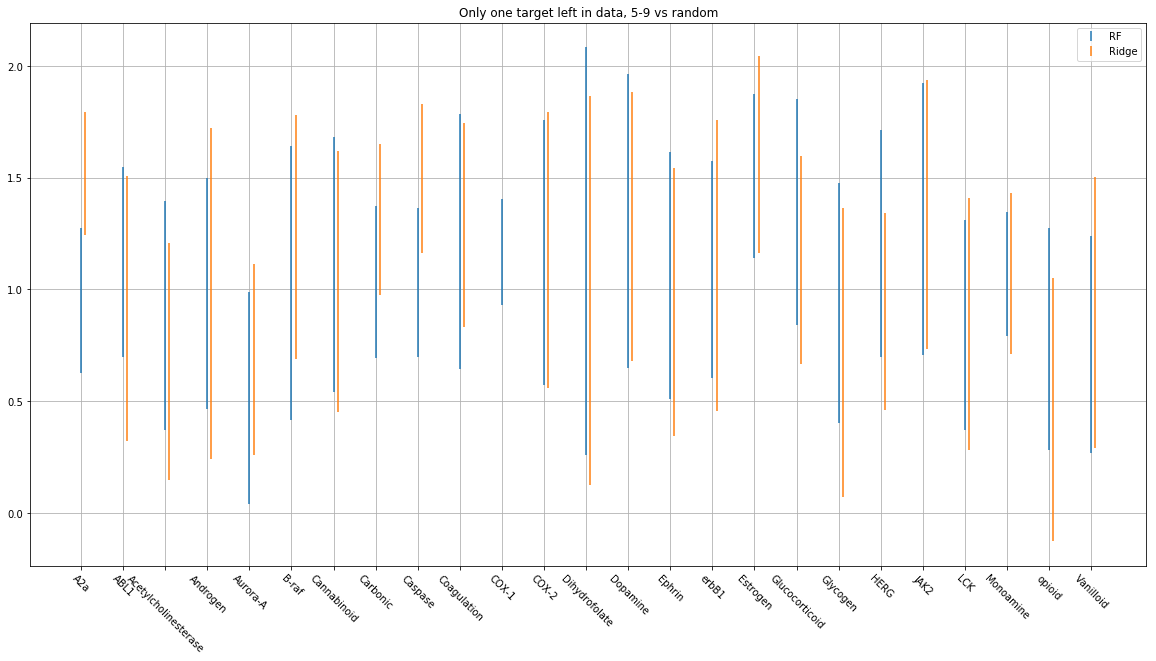

In [31]:
errorbar(np.arange(25), rf5_9, rf5_9e, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd5_9, rd5_9e, label='Ridge', fmt='none')
grid(True)
title('Only one target left in data, 5-9 vs random')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

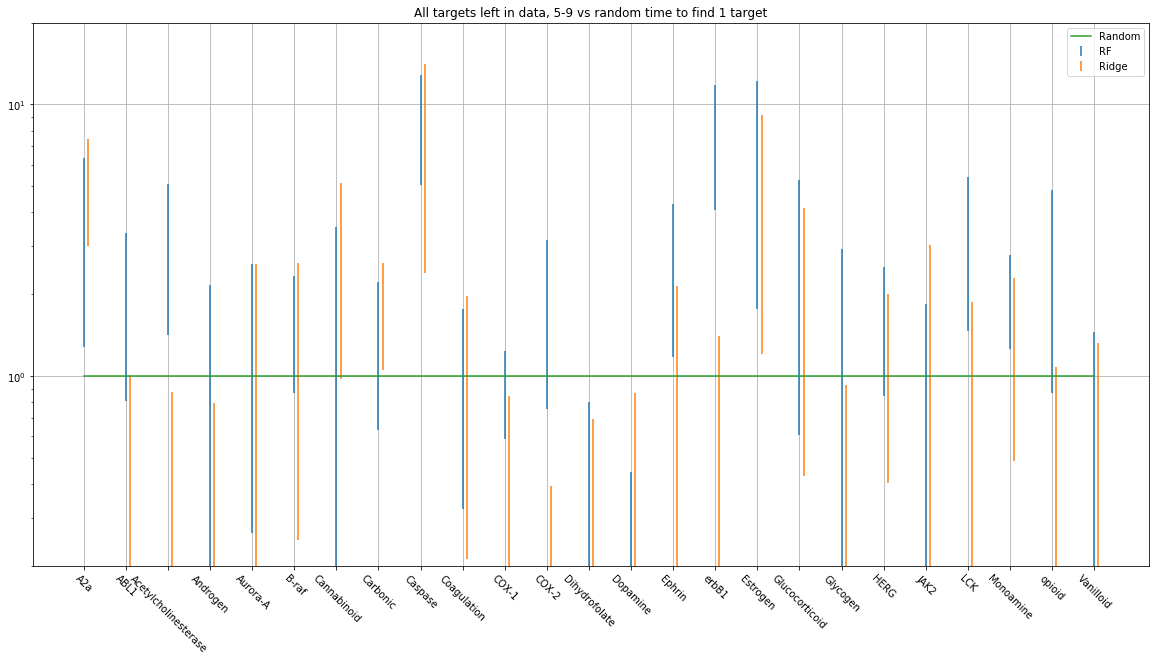

In [32]:
rf5_9 = map(lambda x: full_results_ft07[x]['5_9']['rf']['mean'], targets)
rf5_9e = map(lambda x: full_results_ft07[x]['5_9']['rf']['stderr'], targets)
rd5_9 = map(lambda x: full_results_ft07[x]['5_9']['ridge']['mean'], targets)
rd5_9e = map(lambda x: full_results_ft07[x]['5_9']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf5_9, rf5_9e, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd5_9, rd5_9e, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
yscale('log')
ylim((0.2, 20))
grid(True)
title('All targets left in data, 5-9 vs random time to find 1 target')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

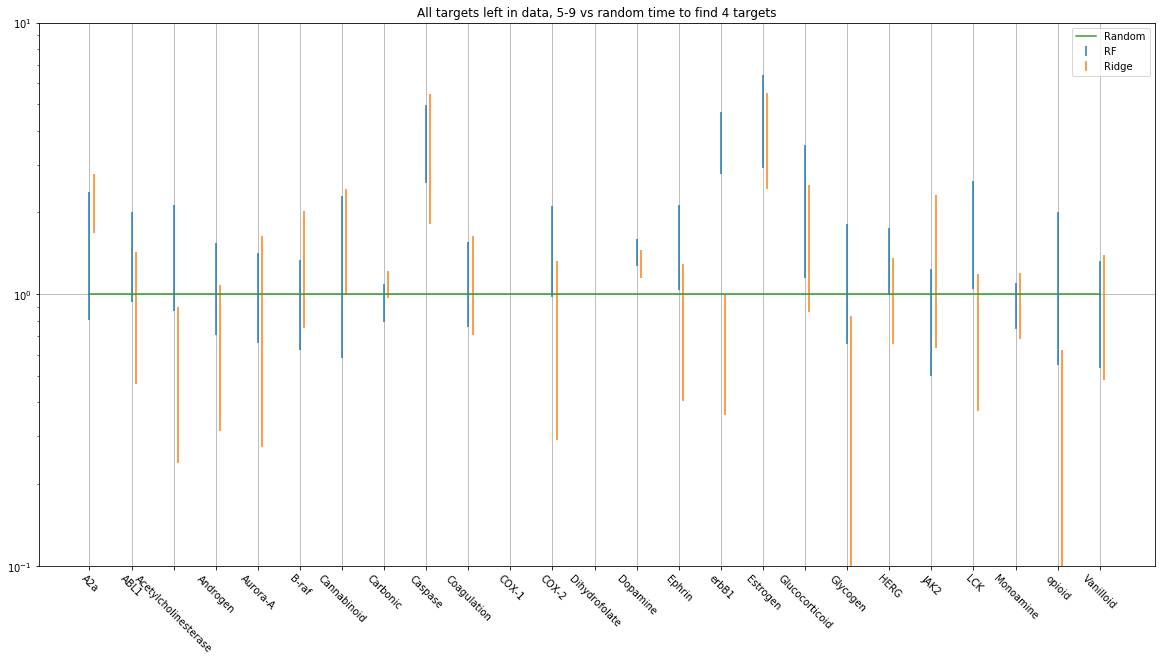

In [33]:
rf5_9 = map(lambda x: full_results_ft07_4[x]['5_9']['rf']['mean'], targets)
rf5_9e = map(lambda x: full_results_ft07_4[x]['5_9']['rf']['stderr'], targets)
rd5_9 = map(lambda x: full_results_ft07_4[x]['5_9']['ridge']['mean'], targets)
rd5_9e = map(lambda x: full_results_ft07_4[x]['5_9']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf5_9, rf5_9e, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd5_9, rd5_9e, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
yscale('log')
ylim((0.1, 10))
grid(True)
title('All targets left in data, 5-9 vs random time to find 4 targets')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

### 7-8

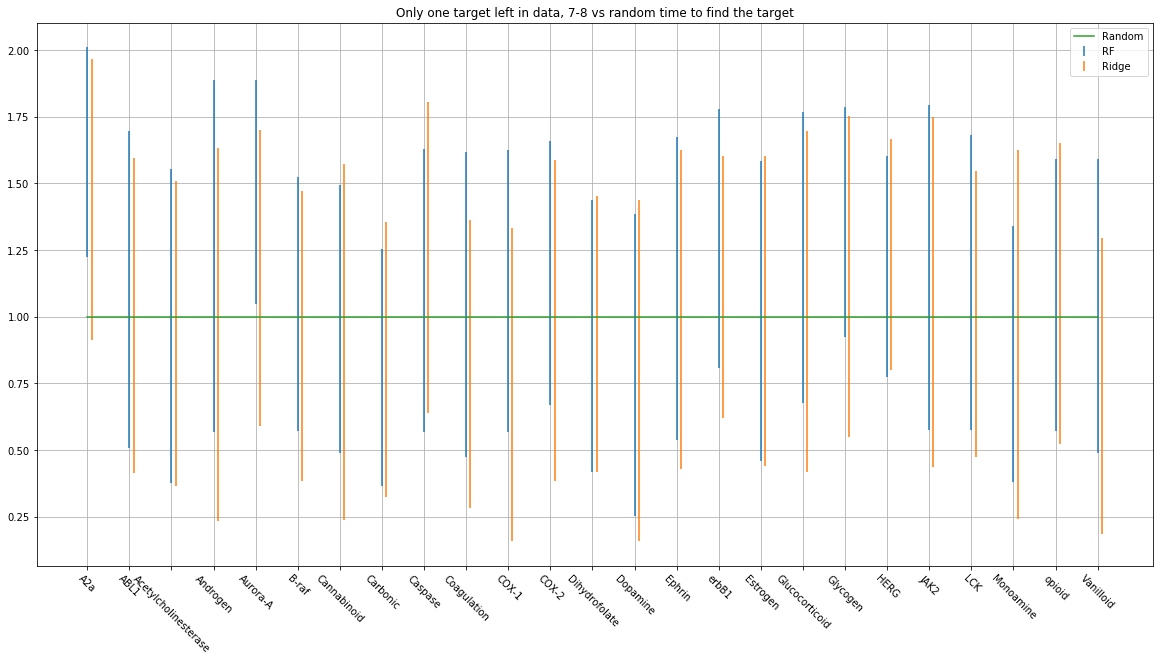

In [34]:
rf5_9 = map(lambda x: full_results_op[x]['7_8']['rf']['mean'], targets)
rf5_9e = map(lambda x: full_results_op[x]['7_8']['rf']['stderr'], targets)
rd5_9 = map(lambda x: full_results_op[x]['7_8']['ridge']['mean'], targets)
rd5_9e = map(lambda x: full_results_op[x]['7_8']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf5_9, rf5_9e, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd5_9, rd5_9e, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('Only one target left in data, 7-8 vs random time to find the target')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

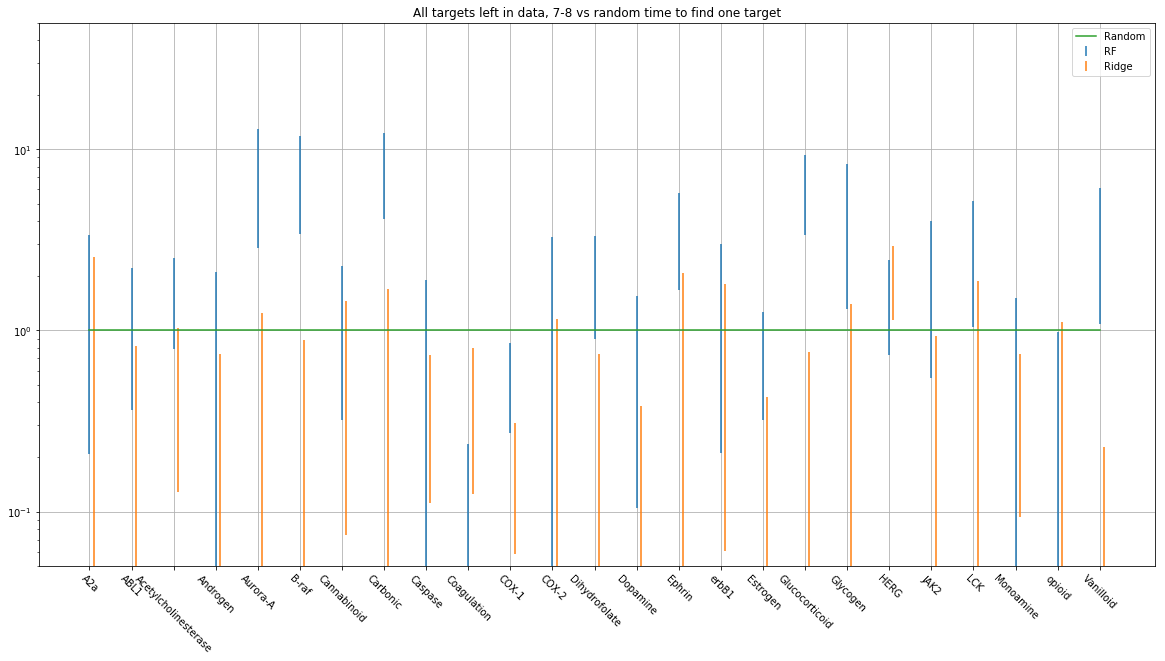

In [35]:
rf5_9 = map(lambda x: full_results_ft07[x]['7_8']['rf']['mean'], targets)
rf5_9e = map(lambda x: full_results_ft07[x]['7_8']['rf']['stderr'], targets)
rd5_9 = map(lambda x: full_results_ft07[x]['7_8']['ridge']['mean'], targets)
rd5_9e = map(lambda x: full_results_ft07[x]['7_8']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf5_9, rf5_9e, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd5_9, rd5_9e, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
yscale('log')
ylim((0.05, 50))
grid(True)
title('All targets left in data, 7-8 vs random time to find one target')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

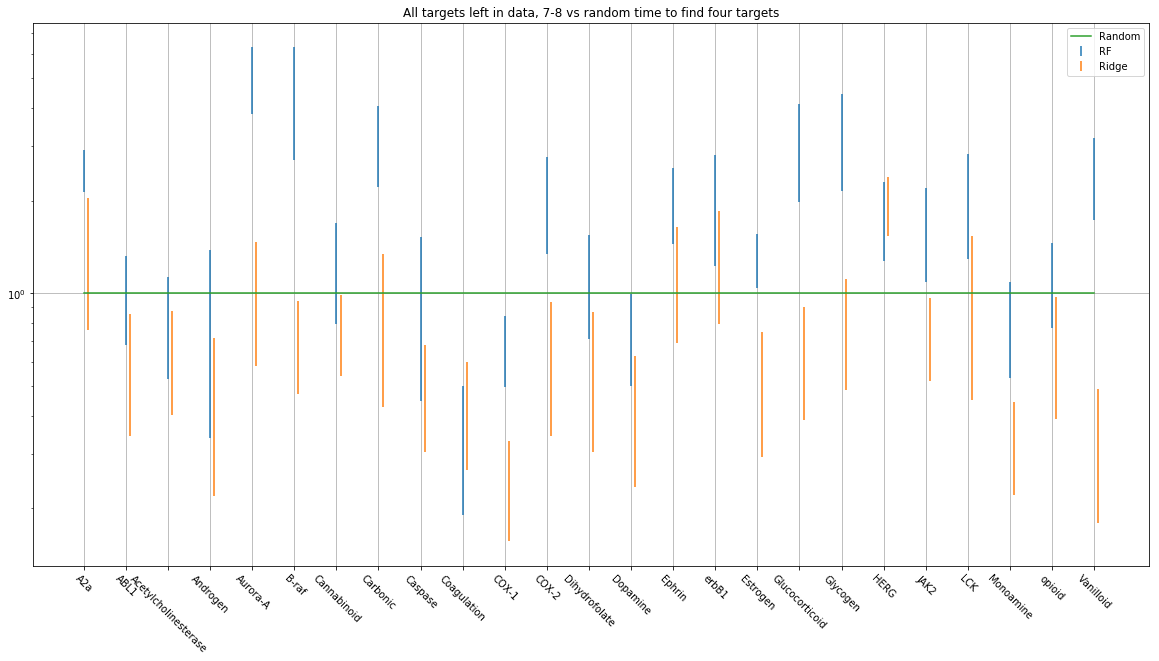

In [36]:
rf5_9 = map(lambda x: full_results_ft07_4[x]['7_8']['rf']['mean'], targets)
rf5_9e = map(lambda x: full_results_ft07_4[x]['7_8']['rf']['stderr'], targets)
rd5_9 = map(lambda x: full_results_ft07_4[x]['7_8']['ridge']['mean'], targets)
rd5_9e = map(lambda x: full_results_ft07_4[x]['7_8']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf5_9, rf5_9e, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd5_9, rd5_9e, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
yscale('log')
grid(True)
title('All targets left in data, 7-8 vs random time to find four targets')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

### Ollie param (only leave one target in) comparison accross multiple target thresholds

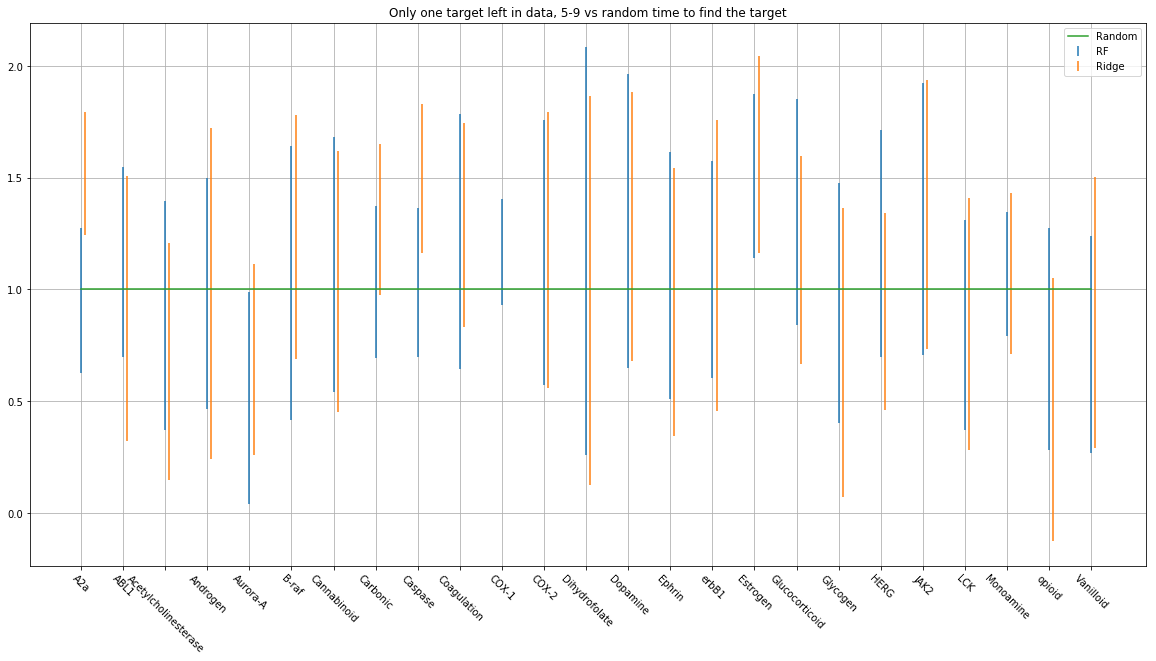

In [37]:
rf = map(lambda x: full_results_op[x]['5_9']['rf']['mean'], targets)
rfe = map(lambda x: full_results_op[x]['5_9']['rf']['stderr'], targets)
rd = map(lambda x: full_results_op[x]['5_9']['ridge']['mean'], targets)
rde = map(lambda x: full_results_op[x]['5_9']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf, rfe, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd, rde, label='Ridge', fmt='none')

plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('Only one target left in data, 5-9 vs random time to find the target')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

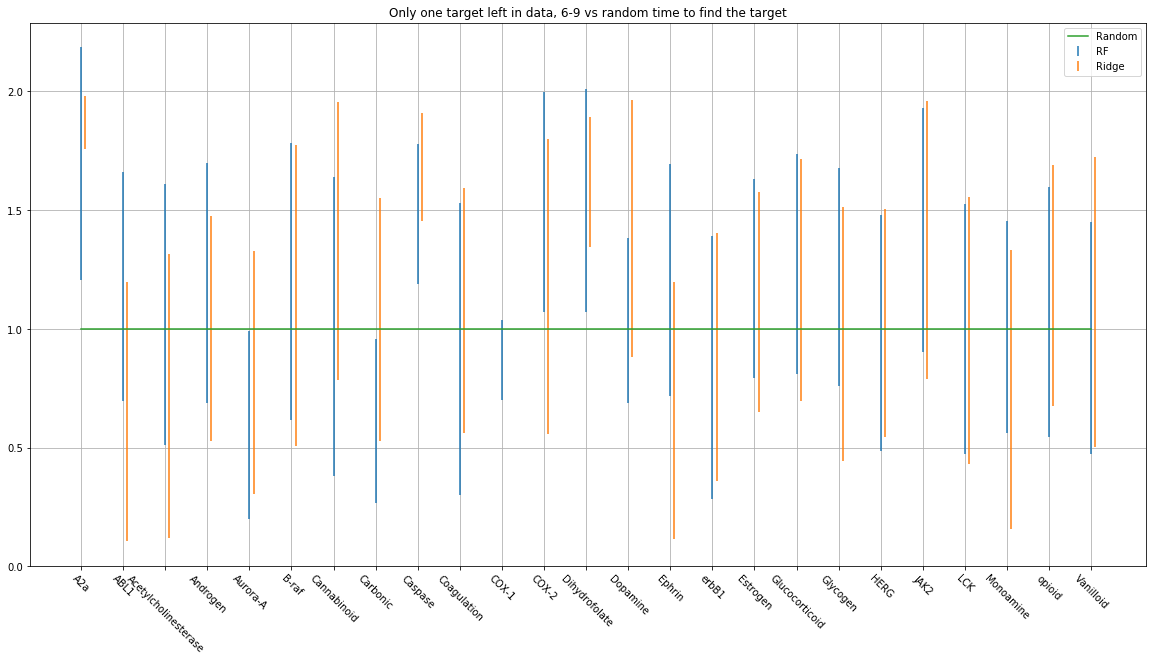

In [38]:
rf = map(lambda x: full_results_op[x]['6_9']['rf']['mean'], targets)
rfe = map(lambda x: full_results_op[x]['6_9']['rf']['stderr'], targets)
rd = map(lambda x: full_results_op[x]['6_9']['ridge']['mean'], targets)
rde = map(lambda x: full_results_op[x]['6_9']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf, rfe, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd, rde, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('Only one target left in data, 6-9 vs random time to find the target')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

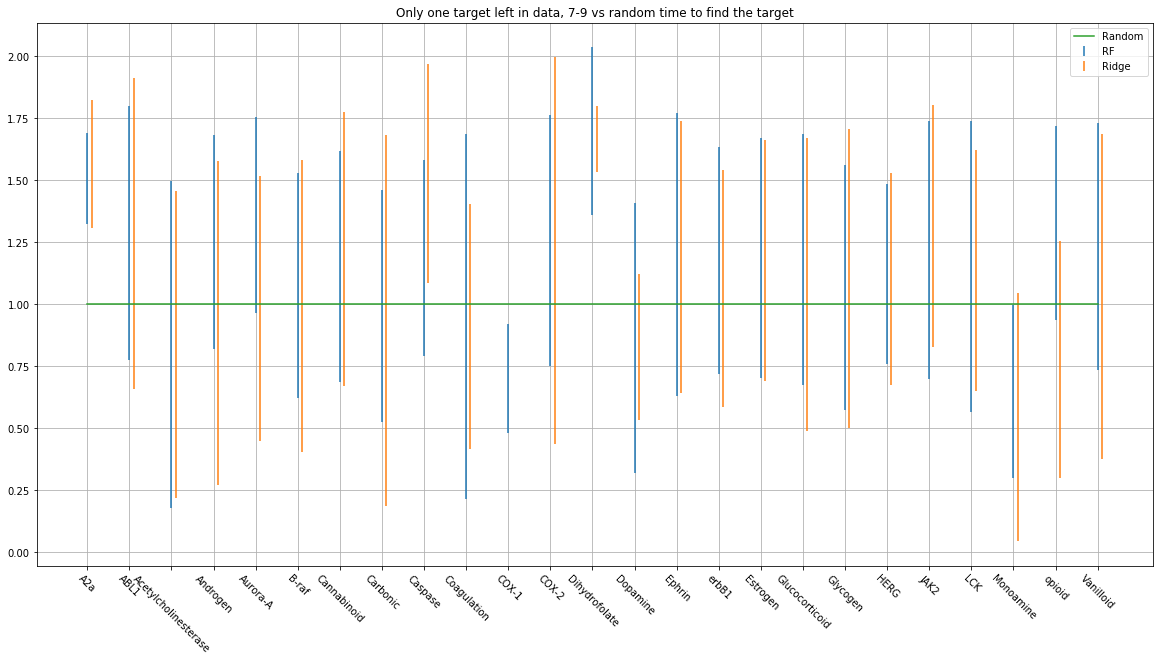

In [39]:
rf = map(lambda x: full_results_op[x]['7_9']['rf']['mean'], targets)
rfe = map(lambda x: full_results_op[x]['7_9']['rf']['stderr'], targets)
rd = map(lambda x: full_results_op[x]['7_9']['ridge']['mean'], targets)
rde = map(lambda x: full_results_op[x]['7_9']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf, rfe, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd, rde, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('Only one target left in data, 7-9 vs random time to find the target')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

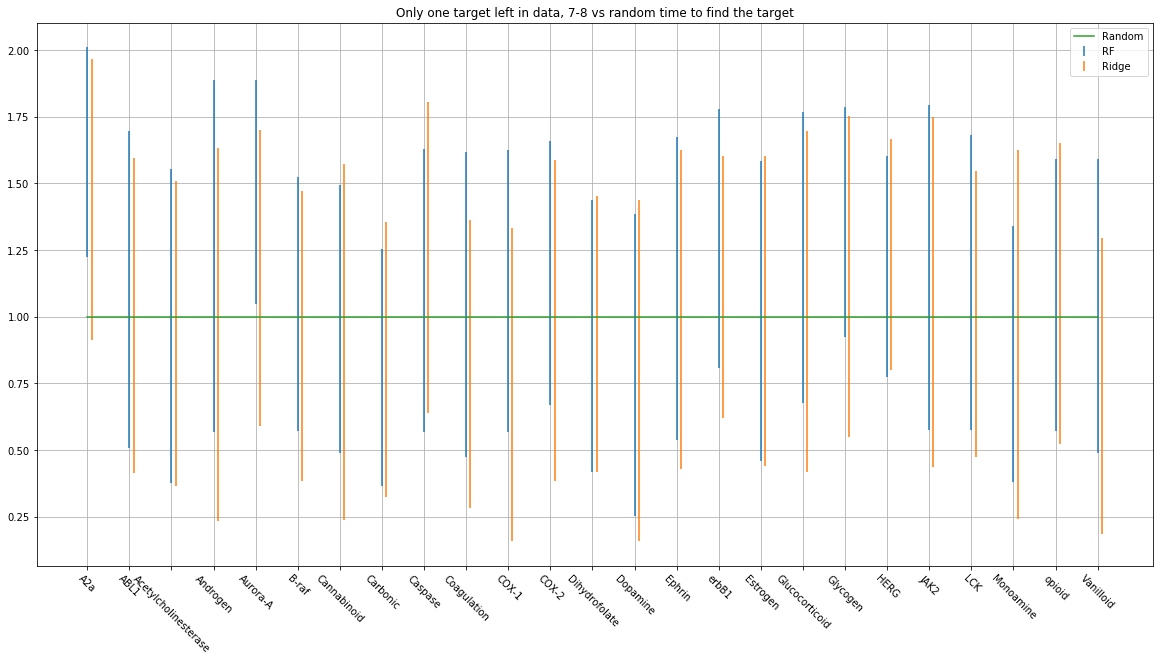

In [40]:
rf = map(lambda x: full_results_op[x]['7_8']['rf']['mean'], targets)
rfe = map(lambda x: full_results_op[x]['7_8']['rf']['stderr'], targets)
rd = map(lambda x: full_results_op[x]['7_8']['ridge']['mean'], targets)
rde = map(lambda x: full_results_op[x]['7_8']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf, rfe, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd, rde, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('Only one target left in data, 7-8 vs random time to find the target')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

### Problem with datasets - not all of them have 4+ 9's.  We need to go the James way and do quantile based results...

In [41]:
for tgt in targets:
    preds, resps, smiles = get_data(tgt)
    print ('%s %d' % (tgt, np.sum(resps >= 9)))

A2a 15
ABL1 12
Acetylcholinesterase 84
Androgen 17
Aurora-A 240
B-raf 223
Cannabinoid 67
Carbonic 4
Caspase 41
Coagulation 15
COX-1 1
COX-2 28
Dihydrofolate 2
Dopamine 6
Ephrin 31
erbB1 156
Estrogen 60
Glucocorticoid 42
Glycogen 37
HERG 21
JAK2 197
LCK 87
Monoamine 5
opioid 25
Vanilloid 28


To do...
    
    Need MPO thing
    Need to do quantile based - you train on a fraction of test data with activity < q1, trying to get something > q2
    Do this based on bootstrap - to avoid having to have a separate parameter to determine what size subset you fit on.
    could do mean prediction / random.

### Quantile based proper bootrap - new loss is mean of predicted actives in the test set vs random.

In [42]:
np.random.choice(10, size=10)

array([3, 7, 0, 3, 3, 8, 4, 9, 7, 5])

In [43]:
x, y, smi = get_data('HERG')

In [86]:
def bs_new_loss(x, y, fit_pct=0.3, find_pct=0.9, num_runs=10, 
                models=['ridge', 'rf'], label=None, debug=False):
    assert find_pct > fit_pct
    
    sorted_indices = np.argsort(y)
    
    num_fit = int(fit_pct * len(y))
    num_find = int(find_pct * len(y))

    val_to_find = y[sorted_indices[num_find]]
    
    if debug:
        print('Fitting on %d and looking to find %d out of %d (cutoff=%.3f)' % 
              (num_fit, np.sum(y >= val_to_find), len(y)-num_fit, val_to_find))
        pass
    
    results_dict = {}
    
    for model in models:      
        results = []
        for i in range(num_runs):
            # this gives the indices to plug into
            bs_sample = np.random.choice(num_fit, size=num_fit)
            train_indices = sorted_indices[bs_sample]
            
            # HERE I'M NOT ADDING IN THE VALUES MISSED BY THE BOOTSTRAP ON THE TRAINING SAMPLE (SHOULD I?).  BIT LAZY
            test_indices = sorted_indices[num_fit:]
            
            mdl = model_dict[model]['m'](**model_dict[model]['kw'])
            
            mdl.fit(x[train_indices], y[train_indices])
            predictions = mdl.predict(x[test_indices])
            ranked = test_indices[np.argsort(-predictions)]
            found = y[ranked] >= val_to_find
            
            # LOSS (so small values are good) is the mean rank of the good molecules in the order
            # you rank them vs random (in which case the mean value would be half the length of the array)
            loss = np.mean(np.arange(len(test_indices))[found])*2/len(test_indices)
            
            if debug:
                print(model)
                print('predictions')
                print(predictions)
                print('\nranked indices')
                print(ranked)
                print('Ranked predictions')
                print(predictions[np.argsort(-predictions)])
                print('\nActuals')
                print(y[ranked])
                print('\nGood indices')
                print(np.arange(len(y))[y >= val_to_find])
                print('\nIndex (in list of predictions) of good ones')
                print(np.arange(len(test_indices))[found], 'out of', len(test_indices))
                print('\nFound')
                print(found)
                print('\nUn-normalized loss')
                print(np.mean(np.arange(len(test_indices))[found]))
                print('\nloss')
                print(loss)
                pass
            
            results.append(loss)
            pass
        
        results_dict[model] = {'mean'   : np.mean(np.asarray(results)), 
                               'stderr' : np.std(np.asarray(results)) / np.sqrt(len(results))}
        pass
    if label is not None:
        return {label : results_dict}
    
    return results_dict

In [45]:
import pdb
bs_new_loss(x, y)

{'rf': {'mean': 1.1056583089023064, 'stderr': 0.013217379221472135},
 'ridge': {'mean': 1.0070354713596386, 'stderr': 0.010821107142235536}}

In [46]:
bs_new_loss(x, y, find_pct=0.98, fit_pct=0.5, num_runs=40)

{'rf': {'mean': 1.1434204667587902, 'stderr': 0.012173289332274437},
 'ridge': {'mean': 1.0421739213879933, 'stderr': 0.014598300353708342}}

In [49]:
# Same functions as above but packaged for multi-processing
def new_loss_wrapper(kw_dict):
    return bs_new_loss(**kw_dict)


# Wraps all the analysis into a single job...
def runner(datasets=['COX-1', ],  num_runs=25, 
           settings=[[0.5, 0.9], [0.5, 0.98], [0.5, 0.99], [0.6, 0.98], [0.6, 0.99]], 
           debug=False):
    
    p = Pool(5)
    dict_list = []
    for dataset in datasets:

        x, y, _ = get_data(dataset)
        kw_dict = {'x' : x, 'y' : y,  'num_runs' : num_runs, 'debug' : debug}

        for setting in settings:
            mykey = dataset + '_' + str(setting[0]) + '_' + str(setting[1])
            kw_dict.update({'fit_pct' : setting[0], 'find_pct' : setting[1]}, label=mykey)
            dict_list.append(deepcopy(kw_dict))
            pass
        pass
    
    results = [p.map(new_loss_wrapper, dict_list)]
    return results

In [48]:
runner()

[[{'COX-1_0.5_0.9': {'rf': {'mean': 1.043414423155606,
     'stderr': 0.006948374335807503},
    'ridge': {'mean': 1.0262759080228658, 'stderr': 0.005906286650717045}}},
  {'COX-1_0.5_0.98': {'rf': {'mean': 1.0942544382054336,
     'stderr': 0.015774602809900833},
    'ridge': {'mean': 0.9500720322159831, 'stderr': 0.015122155189302591}}},
  {'COX-1_0.5_0.99': {'rf': {'mean': 1.167477284328739,
     'stderr': 0.01962775390729226},
    'ridge': {'mean': 0.8742664624808576, 'stderr': 0.021015187619480007}}},
  {'COX-1_0.6_0.98': {'rf': {'mean': 1.1677643226400396,
     'stderr': 0.014385712963015931},
    'ridge': {'mean': 1.0629785425961336, 'stderr': 0.01486813575354246}}},
  {'COX-1_0.6_0.99': {'rf': {'mean': 1.1783811344805608,
     'stderr': 0.018103053554972597},
    'ridge': {'mean': 1.0155971956660295, 'stderr': 0.01900633082293845}}}]]

In [50]:
#full_results = runner(datasets=targets)

In [54]:
#fr = {}
#for d in full_results[0]:
#    fr.update(d)

In [59]:
#joblib.dump(fr, 'models/james_results')

['models/james_results']

In [60]:
fr = joblib.load('models/james_results')

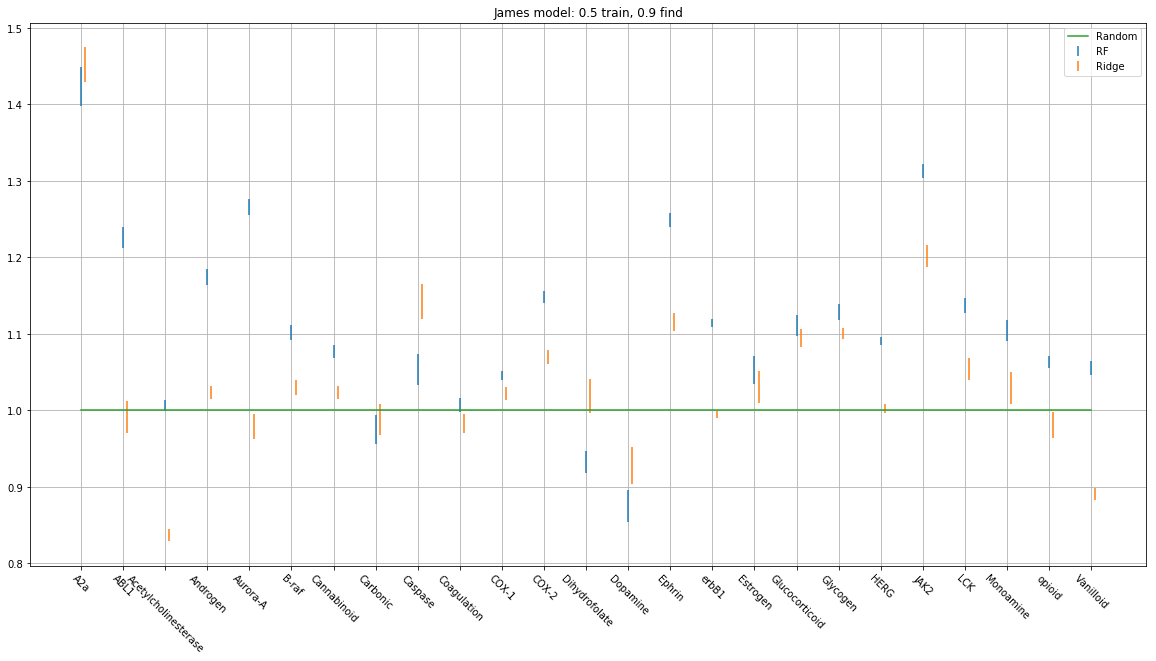

In [55]:
rf = map(lambda x: fr[x + '_0.5_0.9']['rf']['mean'], targets)
rfe = map(lambda x: fr[x + '_0.5_0.9']['rf']['stderr'], targets)
rd = map(lambda x: fr[x + '_0.5_0.9']['ridge']['mean'], targets)
rde = map(lambda x: fr[x + '_0.5_0.9']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf, rfe, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd, rde, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('James model: 0.5 train, 0.9 find')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

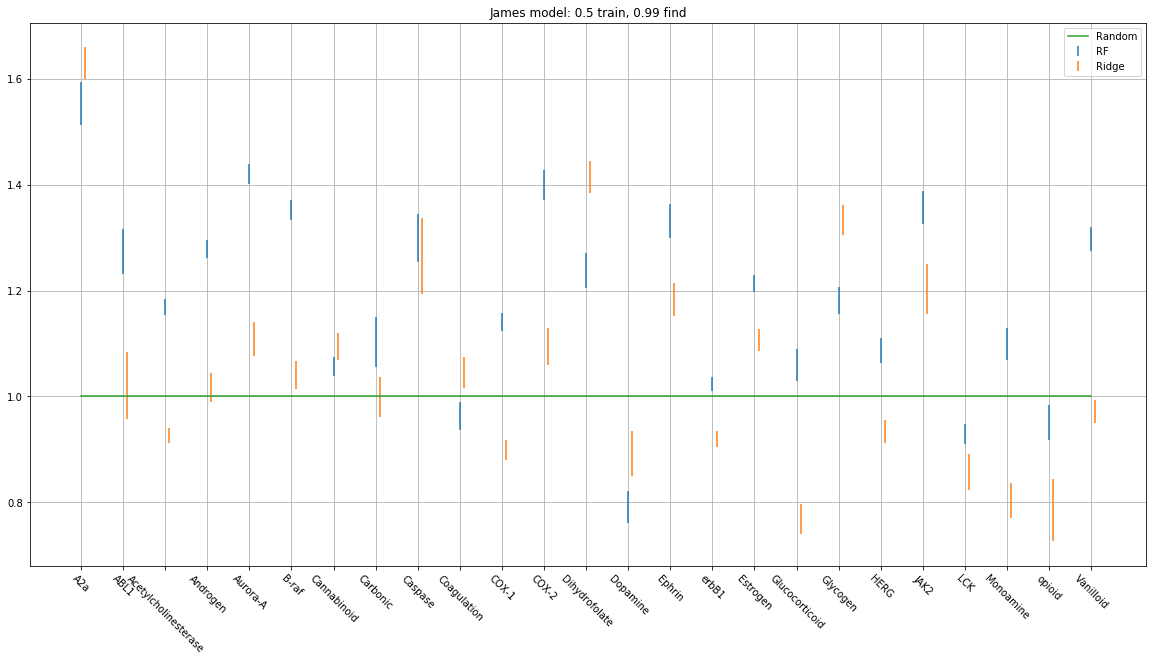

In [56]:
rf = map(lambda x: fr[x + '_0.5_0.99']['rf']['mean'], targets)
rfe = map(lambda x: fr[x + '_0.5_0.99']['rf']['stderr'], targets)
rd = map(lambda x: fr[x + '_0.5_0.99']['ridge']['mean'], targets)
rde = map(lambda x: fr[x + '_0.5_0.99']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf, rfe, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd, rde, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('James model: 0.5 train, 0.99 find')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

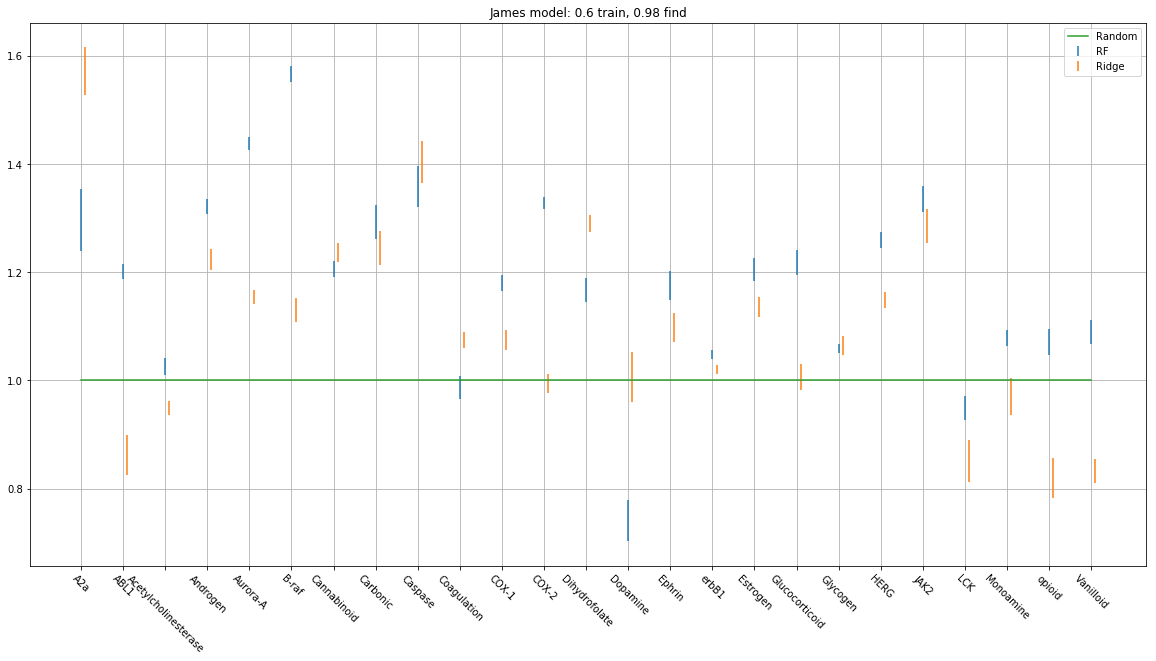

In [57]:
rf = map(lambda x: fr[x + '_0.6_0.98']['rf']['mean'], targets)
rfe = map(lambda x: fr[x + '_0.6_0.98']['rf']['stderr'], targets)
rd = map(lambda x: fr[x + '_0.6_0.98']['ridge']['mean'], targets)
rde = map(lambda x: fr[x + '_0.6_0.98']['ridge']['stderr'], targets)

errorbar(np.arange(25), rf, rfe, label='RF', fmt='none')
errorbar(np.arange(25)+0.1, rd, rde, label='Ridge', fmt='none')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('James model: 0.6 train, 0.98 find')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

### Bollocks... we're gonna have to debug this... so we'll take the following points to debug:

Setting: 0.6 train, 0.98 fine
- A2a (coz it's a nice small dataset)
- Caspase (WTF??? how can anything be this bad???)
- B-raf (coz they're so different)

In [61]:
preds, resps, _ = get_data('A2a')

In [62]:
len(resps)

199

In [87]:
bs_new_loss(x=preds, y=resps, fit_pct=0.8, find_pct=0.98, num_runs=1, debug=True,)

Fitting on 159 and looking to find 4 out of 40 (cutoff=9.530)
ridge
predictions
[4.70607297 6.64789322 6.55121114 5.54694119 4.46626301 7.95983343
 6.47010849 5.55654511 6.2505983  4.05658836 7.17026053 5.76531979
 7.07988426 6.10246087 5.97287228 4.10437076 6.50019427 5.72650745
 5.93348456 7.04391737 6.5101918  6.38537537 3.89300086 6.37649368
 6.68615865 5.86703602 5.05843481 4.83711833 6.47400773 5.27902411
 5.18032181 4.89401296 5.31314641 5.17255642 5.42630738 5.45073168
 5.64289803 5.26693953 5.84224591 5.86977621]

ranked indices
[192 119 132 148  33 110  56 167 180 162  86  14 178 130  17 101  16 116
  87  67  97  30 146  64 153   0 161 103 151 159  84  24  50  25 121 112
  22 172   4 109]
Ranked predictions
[7.95983343 7.17026053 7.07988426 7.04391737 6.68615865 6.64789322
 6.55121114 6.5101918  6.50019427 6.47400773 6.47010849 6.38537537
 6.37649368 6.2505983  6.10246087 5.97287228 5.93348456 5.86977621
 5.86703602 5.84224591 5.76531979 5.72650745 5.64289803 5.55654511
 5.54

{'rf': {'mean': 1.3375, 'stderr': 0.0},
 'ridge': {'mean': 1.0875, 'stderr': 0.0}}

In [88]:
pred_hrg, resp_herg, _ = get_data('HERG')

In [89]:
len(resp_herg)

5010

Ideas...

- Definitely, add the bootstrap complement to the test set.
- Don't need fit pct to be < find pct any more (maybe just fix find pct)
- Can look at lowering the fit max threshold, how does stuff deteriorate (hopefully some threshold where these models beat random)
- IC50 inverse weighted bootstrap
- Add in, SVN, Deep net
- Look at within sample score